# Step 4: Model Fitting to Predict Pitchfork Scores

It's unclear what kind of regression model will be the best fit for predicting the scores of the pitchfork albums. Towards the end of the previous notebook, I would use `GridSearch` twice when fitting one model: once to see what the optimal `CountVectorizer` hyperparameters would be with a given regression technique, and then again to see what the optimal hyperparameters would be of the chosen regression model.

The results of taking this approach were that optimal `CountVectorizer` hyperparameters would change with different regression techniques. I had hoped this wouldn't happen: taking this approach was very time consuming, and would prohibit me from using the same `X_train`, `X_test`, `y_train` and `y_test` datasets that had been preprocessed with the same `CountVectorizer` hyperparameters. 

However, I noted that the differences of searching for the "best" parameters possible for each Regression technique returned marginal results that didn't justify the length of time that taking this approach took. For that reason, I began this notebook by generating one instance of `X_train`, `X_test`, `y_train` and `y_test` that was then used in fitting and predicting values for each model. The hyperparameters used in the `CountVectorizer` instance were found from `GridSearching` with a `LinearRegression` model.

**Make necessary imports**

In [173]:
import pandas as pd
import numpy as np
from sklearn import metrics
import regex as re
import pickle
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from tensorflow.keras.regularizers import l2

**Read in `dataframe`, `stopwords` list**

In [3]:
# Read in dataframe
df = pd.read_csv('../datasets/final-datasets/tokenized/cleaned_dummied_tokenized_reviews.csv')

# Set index to be equal to the name of the album
df.set_index('album', inplace = True)

# Read in stopwords list created in previous notebook
stop = pd.read_csv('../datasets/final-datasets/tokenized/stop_words_tokenized.csv')

# Convert stop words to a list that can be referenced in CountVectorizer instance below
stop = [word for word in stop['stop_words']]

**Create `X` and `y` variables, `CountVectorize` the `review` column, and generate a `train_test_split`**

In [104]:
# Define features to be used in X
features = ['review', 'release_date', 'review_length', 'artist_freq', 'label_freq', 
            'Electronic', 'Experimental', 'Folk/Country', 'Global', 'Jazz', 'Metal', 
            'Pop/R&B', 'Rap', 'Rock']

# Define X and y
X = df[features]
y = df['score']



# Do a train_test_split of X and y
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 1957) # Always use random_state = 1957 in
                                                                         # this project

# Instantiate instance of CountVectorizer with optimal hyperparameters from previous notebook
cvec = CountVectorizer(max_df = 0.9, 
                       max_features = 2000, 
                       min_df = 2, 
                       ngram_range = (1, 4), 
                       stop_words = stop)

# Define variable review_train in order to CountVectorize the reviews
review_train = cvec.fit_transform(X_train['review']).astype('int8')
review_train = pd.DataFrame(review_train.toarray(),
                            columns = cvec.get_feature_names(), 
                            index = X_train.index)

# Concat the results of the CountVectorizing with X_train
X_train = pd.concat([X_train, review_train], ignore_index = False, axis = 1)

# Define variable review_test in order to CountVectorize the reviews
review_test = cvec.transform(X_test['review']).astype('int8')
review_test = pd.DataFrame(review_test.toarray(),
                           columns = cvec.get_feature_names(),
                           index = X_test.index)

# Concat the results of the CountVectorizing with X_test
X_test = pd.concat([X_test, review_test], ignore_index = False, axis = 1)

# Now that CountVectorizing is complete, drop the review column from both X_train and X_test
X_train.drop(columns = ['review'], inplace = True)
X_test.drop(columns = ['review'], inplace = True)

# Save work back to datasets folder
#X_train.to_csv('../datasets/final-datasets/tokenized/X_train_token.csv')
#X_test.to_csv('../datasets/final-datasets/tokenized/X_test_token.csv')

#y_train.to_csv('../datasets/final-datasets/tokenized/y_train_token.csv')
#y_test.to_csv('../datasets/final-datasets/tokenized/y_test_token.csv')

## Selecting and fitting various regression models

In the rest of this notebook, we'll be taking a looks at different regression models and seeing how well each one does at predicting pitchfork scores

### **Linear Regression Model**

In [131]:
# Instantiate an instance of a Linear Regression Model
lr = LinearRegression()

# Fit model to X_train and y_train
lr.fit(X_train, y_train)

# Create Linear Regression predictions
preds_lr = lr.predict(X_test)

# Create residuals variable from y_test and the predictions variable from above
resids_lr = y_test - preds_lr

# Find MSE and assign it to a variable
mse_lr = metrics.mean_squared_error(y_test, preds_lr)

# Find RMSE and assign it to a variable
rmse_lr = np.sqrt(mse_lr)

print(f'Train score of this model is {lr.score(X_train, y_train)}')
print(f'Test score of this model is {lr.score(X_test, y_test)}')
print(f'Cross val score is {cross_val_score(lr, X_train, y_train, cv = 5).mean()}')
print(f'The mean squared error is {mse_lr}')
print(f'The root mean squared error is {rmse_lr}')

filename_lr = 'linear_regression_model.sav'
pickle.dump(lr, open(filename_lr, 'wb'))

# This model is overfit on training data and does a poor job of explaining the variablitiy in the data

Train score of this model is 0.4273423425272904
Test score of this model is 0.24106052820955717
Cross val score is 0.1655824323420298
The mean squared error is 1.1278669371396735
The root mean squared error is 1.0620107989750733


**Visualize predictions vs. `y_test` for 1st 100 albums**

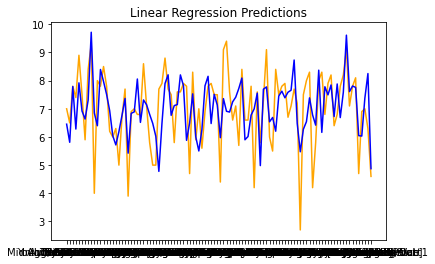

In [150]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_lr[:100], color = 'blue')
plt.title('Linear Regression Predictions');

**Determine which words of most indicative of positive and negative reviews**

We can look at the largest and smallest coefficients from our model, pair them with their labels, and determine which words are most indicative of positive and negative reviews.

In [107]:
# Create a dataframe pairing coefficients with their labels
lr_coef = pd.DataFrame(columns = ['variables', 'coefficient'])

# Assign list equal to those columns in the dataframe
lr_coef['variables'] = X_train.columns
lr_coef['coefficient'] = lr.coef_

**Negative words**

In [108]:
# Use the groupby technique to sort variables by their coefficient values
lr_coef.groupby('variables')['coefficient'].mean().sort_values().head(20)

variables
bland           -0.603728
fails           -0.550487
generic         -0.494880
grating         -0.428476
forgettable     -0.380119
terrible        -0.369277
frustrating     -0.366227
sadly           -0.359832
plodding        -0.352994
painfully       -0.345272
limp            -0.336519
disappointing   -0.327354
awful           -0.326391
assume          -0.324391
suffers         -0.306715
embarrassing    -0.299633
lacking         -0.292418
fail            -0.289897
insight         -0.284502
parody          -0.283960
Name: coefficient, dtype: float64

**Positive words**

In [109]:
lr_coef.groupby('variables')['coefficient'].mean().sort_values(ascending = False).head(20)

variables
infectious      0.248626
seamlessly      0.234532
laptop          0.234006
deluxe          0.229977
gut             0.226626
Global          0.222288
seamless        0.221902
unhinged        0.221705
brutal          0.219704
connections     0.217965
brash           0.213827
devastating     0.208117
giddy           0.207578
raising         0.200006
countless       0.197329
mesmerizing     0.194114
casually        0.191091
diversity       0.189454
threads         0.188279
effortlessly    0.187297
Name: coefficient, dtype: float64

### **Ridge Regressor**

In [185]:
from sklearn.linear_model import Ridge

In [186]:
# Instantiate an instance of a Linear Regression Model
ridge = Ridge()

# Fit model to X_train and y_train
ridge.fit(X_train, y_train)

# Create Linear Regression predictions
preds_ridge = ridge.predict(X_test)

# Create residuals variable from y_test and the predictions variable from above
resids_ridge = y_test - preds_ridge

# Find MSE and assign it to a variable
mse_ridge = metrics.mean_squared_error(y_test, preds_ridge)

# Find RMSE and assign it to a variable
rmse_ridge = np.sqrt(mse_ridge)

print(f'Train score of this model is {ridge.score(X_train, y_train)}')
print(f'Test score of this model is {ridge.score(X_test, y_test)}')
print(f'Cross val score is {cross_val_score(ridge, X_train, y_train, cv = 5).mean()}')
print(f'The mean squared error is {mse_ridge}')
print(f'The root mean squared error is {rmse_ridge}')

filename_ridge = 'linear_regression_ridge_model.sav'
pickle.dump(ridge, open(filename_ridge, 'wb'))

# This model is exactly the same as the baseline linear regression model

Train score of this model is 0.4273399364830439
Test score of this model is 0.24195083082333613
Cross val score is 0.16748806489868115
The mean squared error is 1.1265438502276681
The root mean squared error is 1.0613877002432561


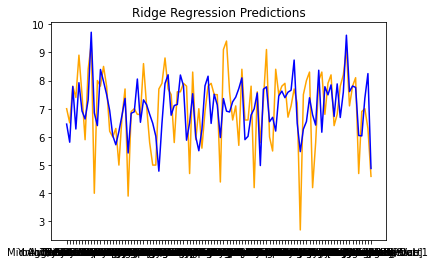

In [190]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_ridge[:100], color = 'blue')
plt.title('Ridge Regression Predictions');

### **Decision Tree Regressor**

In [17]:
grid_dtr = GridSearchCV(estimator = DecisionTreeRegressor(),
                    param_grid = {'max_depth' : [2, 3, 5, 7],
                                  'min_samples_split' : [5, 10, 15, 20],
                                  'min_samples_leaf' : [2, 3, 4, 5, 6],
                                  'ccp_alpha' : [0, 0.001, 0.01, 0.1, 10]},
                    cv = 5)


grid_dtr.fit(X_train, y_train)
preds_dtr = grid_dtr.predict(X_test)
resids_dtr = y_test - preds_dtr
mse_dtr = metrics.mean_squared_error(y_test, preds_dtr)
rmse_dtr = np.sqrt(mse_dtr)

print(f'Train score of this model is {grid_dtr.score(X_train, y_train)}')
print(f'Test score of this model is {grid_dtr.score(X_test, y_test)}')
print()
print(f'The mean squared error is {mse_dtr}')
print(f'The root mean squared error is {rmse_dtr}')
print()
print(f'The best parameters of this model are {grid_dtr.best_params_}')
print(f'The best score of this model are {grid_dtr.best_score_}')

filename_dtr = 'decision_tree_regression_model.sav'
pickle.dump(grid_dtr, open(filename_dtr, 'wb'))

# This model is woefully underfit for both train and test data

Train score of this model is 0.15866152060098682
Test score of this model is 0.1121612318209958

The mean squared error is 1.3194253683729986
The root mean squared error is 1.1486624257687716

The best parameters of this model are {'ccp_alpha': 0.001, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 15}
The best score of this model are 0.10890118937042303


**Visualize predictions vs. `y_test` for 1st 100 albums**

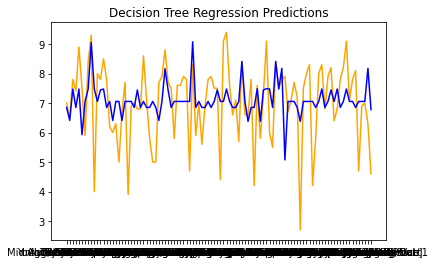

In [151]:
dtr = pickle.load(open('decision_tree_regression_model.sav', 'rb'))
preds_dtr = dtr.predict(X_test)

plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_dtr[:100], color = 'blue')
plt.title('Decision Tree Regression Predictions');

### **Bagging Regressor**

In [38]:
# Make necessary imports 
from sklearn.ensemble import BaggingRegressor

# Create GridSearch 
bag_grid = GridSearchCV(estimator = BaggingRegressor(),
                        param_grid = {
                            'n_estimators' : [5, 15, 25],
                            'max_samples' : [1.0, 2.0],
                            'max_features' : [1.0, 2.0]
                        },
                        cv = 5)

# Fit model
bag_grid.fit(X_train, y_train)

# Generate predictions
preds_bag = bag_grid.predict(X_test)

# Calculate residuals
resids_bag = y_test - preds_bag

# Calculate MSE
mse_bag = metrics.mean_squared_error(y_test, preds_bag)

# Calculate RMSE
rmse_bag = np.sqrt(mse_bag)

print(f'Train score of this model is {bag_grid.score(X_train, y_train)}')
print(f'Test score of this model is {bag_grid.score(X_test, y_test)}')
print()
print(f'The mean squared error is {mse_bag}')
print(f'The root mean squared error is {rmse_bag}')
print()
print(f'The best parameters of this model are {bag_grid.best_params_}')
print(f'The best score of this model are {bag_grid.best_score_}')

filename_bag = 'bagged_regression_model.sav'
pickle.dump(bag_grid, open(filename_bag, 'wb'))

# This model is extremely overfit, with 87% of the variance in the data being explained by the model,
#\n but with only a 17% accuracy score on the testing data

/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/s

/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/Users/michaellaccavole/opt/anaconda3/lib/python3.7/site-packag

Train score of this model is 0.8749635132482606
Test score of this model is 0.1749343769720888

The mean squared error is 1.2261376193656095
The root mean squared error is 1.1073109858416512

The best parameters of this model are {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 25}
The best score of this model are 0.17038283763583914


**Visualize predictions vs. `y_test` for 1st 100 albums**

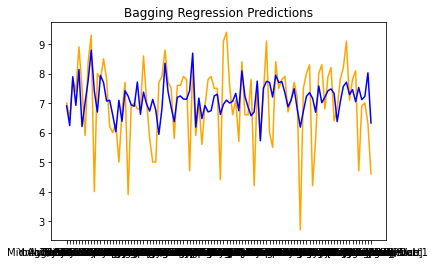

In [152]:
bag = pickle.load(open('bagged_regression_model.sav', 'rb'))
preds_bag = bag.predict(X_test)

plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_bag[:100], color = 'blue')
plt.title('Bagging Regression Predictions');

### **Nueral Network -- Keras Regressor**

In [110]:
# Make necessary imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

# Instantiate a Standard Scaler to scale data
ss = StandardScaler()

# Scale X_train and X_test
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# The below function was taught to us by Riley Dallas of General Assembly
def model_fn(layer_one_neurons = 32, layer_two_neurons = 32, layer_one_dropout = 0.5):
    
    # Instantiate Sequential model
    model = Sequential()
    
    # Add dense layer
    model.add(Dense(layer_one_neurons,
                    activation = 'relu',
                    input_shape = (2013, )))
    
    # Add drop out layer
    model.add(Dropout(layer_one_dropout))
    
    # Add dense layer
    model.add(Dense(layer_two_neurons,
                    activation = 'relu'))
    
    # Add output layer
    model.add(Dense(1, 
                    activation = None))
    
    # Compile the results on the loss parameter MSE and use the optimizer 'adam'
    model.compile(loss = 'mse', optimizer = 'adam')
    
    return model

# Call function with Keras Regressor
nn = KerasRegressor(build_fn = model_fn, batch_size = 512, verbose = 0) # verbose means it won't print 1000 epochs

# Define parameters to be GridSearched over
nn_params = {
    'epochs' : [20, 50, 100, 150],
    'layer_one_neurons' : [20, 32, 64, 128],
    'layer_one_dropout' : [0.1, 0.2, 0.3, 0.4, 0.5],
    'layer_two_neurons' : [16, 32, 64, 128]
}

# Execute gridsearch
gs_nn = GridSearchCV(nn, param_grid = nn_params, cv = 5) 

# Fit the model
gs_nn.fit(X_train_sc, y_train)

This neural network's best score is -1.3586989879608153
This neural network's best parameters are {'epochs': 150, 'layer_one_dropout': 0.5, 'layer_one_neurons': 64, 'layer_two_neurons': 16}
This neural network's MSE is 1.1797530703270684
This neural network's RMSE is 1.0861643845786275


In [171]:
preds_gs_nn_train = gs_nn.predict(X_train_sc)
preds_gs_nn_test = gs_nn.predict(X_test_sc)
mse_gs_nn = metrics.mean_squared_error(y_test, preds_gs_nn_test)
rmse_gs_nn = np.sqrt(mse_gs_nn)
train_acc_gs_nn = metrics.r2_score(y_train, preds_gs_nn_train)
test_acc_gs_nn = metrics.r2_score(y_test, preds_gs_nn_test)


print(f"This neural network's train score is {train_acc_gs_nn}")
print(f"This neural network's test score is {test_acc_gs_nn}")
print(f"This neural network's best parameters are {gs_nn.best_params_}")
print(f"This neural network's MSE is {mse_gs_nn}")
print(f"This neural network's RMSE is {rmse_gs_nn}")

This neural network's train score is 0.8591524114985024
This neural network's test score is 0.20614644994571896
This neural network's best parameters are {'epochs': 150, 'layer_one_dropout': 0.5, 'layer_one_neurons': 64, 'layer_two_neurons': 16}
This neural network's MSE is 1.1797530703270684
This neural network's RMSE is 1.0861643845786275


**Visualize predictions vs. `y_test` for 1st 100 albums**

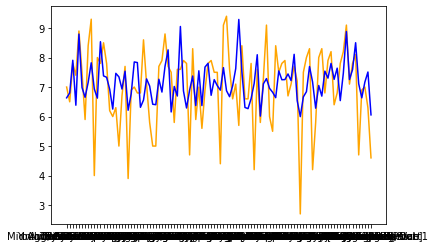

In [128]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_gs_nn[:100], color = 'blue');

### **Call function for a 2nd Neural Network model**

In [112]:
# Call function again
nn2 = KerasRegressor(build_fn = model_fn, batch_size = 512, verbose = 0)

# Define new parameters to GridSearch over
nn2_params = {
    'epochs' : [150, 200, 250],
    'layer_one_neurons' : [64],
    'layer_one_dropout' : [0.5, 0.6, 0.7],
    'layer_two_neurons' : [8, 16]
}
gs_nn2 = GridSearchCV(nn2, param_grid = nn2_params, cv = 5) 

gs_nn2.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1a25481a90>,
             iid='deprecated', n_jobs=None,
             param_grid={'epochs': [150, 200, 250],
                         'layer_one_dropout': [0.5, 0.6, 0.7],
                         'layer_one_neurons': [64],
                         'layer_two_neurons': [8, 16]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [170]:
preds_gs_nn2_train = gs_nn2.predict(X_train_sc)
preds_gs_nn2_test = gs_nn2.predict(X_test_sc)
mse_gs_nn2 = metrics.mean_squared_error(y_test, preds_gs_nn2_test)
rmse_gs_nn2 = np.sqrt(mse_gs_nn2)
train_acc_gs_nn2 = metrics.r2_score(y_train, preds_gs_nn2_train)
test_acc_gs_nn2 = metrics.r2_score(y_test, preds_gs_nn2_test)

print(f"This neural network's train score is {train_acc_gs_nn2}")
print(f"This neural network's test score is {test_acc_gs_nn2}")
print(f"This neural network's best parameters are {gs_nn2.best_params_}")
print(f"This neural network's MSE is {mse_gs_nn2}")
print(f"This neural network's RMSE is {rmse_gs_nn2}")

This neural network's train score is 0.6646233200130229
This neural network's test score is 0.22481020009120944
This neural network's best parameters are {'epochs': 150, 'layer_one_dropout': 0.7, 'layer_one_neurons': 64, 'layer_two_neurons': 8}
This neural network's MSE is 1.1520166993850298
This neural network's RMSE is 1.0733204085383963


**Visualize predictions vs. `y_test` for 1st 100 albums**

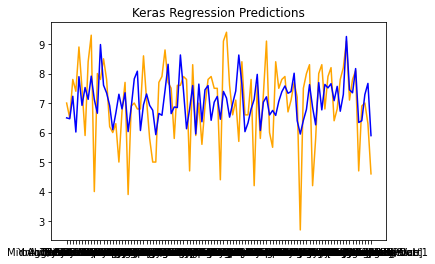

In [153]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_gs_nn2[:100], color = 'blue')
plt.title('Keras Regression Predictions');

### **Custom build a 3rd Neural Network**

This Neural Network uses the optimal hyperparameters found from GridSearching with the above Neural Network function.

In [179]:
# Instantiate Sequential model
nn_3_layer = Sequential()

# Add dense layer
nn_3_layer.add(Dense(64,
               activation = 'relu',
               input_shape = (2013, )))

# Add dropout layer
nn_3_layer.add(Dropout(0.7))

# Add 2nd dense layer
nn_3_layer.add(Dense(16,
                     activation = 'relu'))

# Add second dropout layer
nn_3_layer.add(Dropout(0.4))

# Add 3rd dense layer
nn_3_layer.add(Dense(8,
                     activation = 'relu'))

# Add 4th dense layer
nn_3_layer.add(Dense(8,
                     activation = 'relu'))

# Add output layer    
nn_3_layer.add(Dense(1, 
                activation = None))

# Compile results, choose MSE as loss function and 'adam' as optimizer
nn_3_layer.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

# Fit model, choose number of epochs and batch size
hist_3 = nn_3_layer.fit(X_train_sc, y_train, 
           epochs = 1000, 
           batch_size = 128,
           validation_data = (X_test_sc, y_test),
           verbose = 0)

**Define predictions, MSE, and RMSE**

In [180]:
preds_hist_3_test = nn_3_layer.predict(X_test_sc)
preds_hist_3_train = nn_3_layer.predict(X_train_sc)
mse_hist_3 = metrics.mean_squared_error(y_test, preds_hist_3)
rmse_hist_3 = np.sqrt(mse_hist_3)
train_acc_hist_3 = metrics.r2_score(y_train, preds_hist_3_train)
test_acc_hist_3 = metrics.r2_score(y_test, preds_hist_3_test)


print(f"This neural network's train score is {train_acc_hist_3}")
print(f"This neural network's test score is {test_acc_hist_3}")
print(f"This neural network's MSE is {mse_hist_3}")
print(f"This neural network's RMSE is {rmse_hist_3}")

# This model is very overfit

This neural network's train score is 0.7725297187369728
This neural network's test score is 0.22213197278972496
This neural network's MSE is 1.175292682886577
This neural network's RMSE is 1.0841091655763164


**Visualize predictions vs. `y_test` for 1st 100 albums**

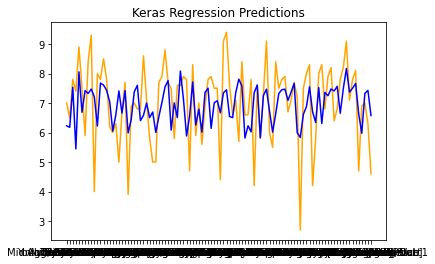

In [183]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_hist_3[:100], color = 'blue')
plt.title('Keras Regression Predictions');

**Copy the above Neural Network with l2 Regularizer (Ridge Regression)**

In [175]:
# Instantiate Sequential model
nn_3_layer_l2 = Sequential()

# Add dense layer
nn_3_layer_l2.add(Dense(64,
               activation = 'relu',
               input_shape = (2013, ),
               kernel_regularizer = l2(0.005)))

# Add dropout layer
nn_3_layer_l2.add(Dropout(0.7))

# Add 2nd dense layer
nn_3_layer_l2.add(Dense(16,
                     activation = 'relu',
                     kernel_regularizer = l2(0.005)))

# Add second dropout layer
nn_3_layer_l2.add(Dropout(0.4))

# Add 3rd dense layer
nn_3_layer_l2.add(Dense(8,
                     activation = 'relu',
                     kernel_regularizer = l2(0.005)))

# Add 4th dense layer
nn_3_layer_l2.add(Dense(8,
                     activation = 'relu',
                     kernel_regularizer = l2(0.005)))

# Add output layer    
nn_3_layer_l2.add(Dense(1, 
                activation = None))

# Compile results, choose MSE as loss function and 'adam' as optimizer
nn_3_layer_l2.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

# Fit model, choose number of epochs and batch size
hist_3_l2 = nn_3_layer_l2.fit(X_train_sc, y_train, 
           epochs = 1000, 
           batch_size = 128,
           validation_data = (X_test_sc, y_test),
           verbose = 0)

**Define predictions, MSE, and RMSE**

In [178]:
preds_hist_3_l2_test = nn_3_layer.predict(X_test_sc)
preds_hist_3_l2_train = nn_3_layer.predict(X_train_sc)
mse_hist_3_l2 = metrics.mean_squared_error(y_test, preds_hist_3_l2_test)
rmse_hist_3_l2 = np.sqrt(mse_hist_3_l2)
train_acc_hist_3_l2 = metrics.r2_score(y_train, preds_hist_3_l2_train)
test_acc_hist_3_l2 = metrics.r2_score(y_test, preds_hist_3_l2_test)


print(f"This neural network's train score is {train_acc_hist_3_l2}")
print(f"This neural network's test score is {test_acc_hist_3_l2}")
print(f"This neural network's MSE is {mse_hist_3_l2}")
print(f"This neural network's RMSE is {rmse_hist_3_l2}")

# This model is very overfit

This neural network's train score is 0.5958333217534347
This neural network's test score is 0.2562834484241724
This neural network's MSE is 1.1052440152401515
This neural network's RMSE is 1.0513058618880384


**Visualize predictions vs. `y_test` for 1st 100 albums**

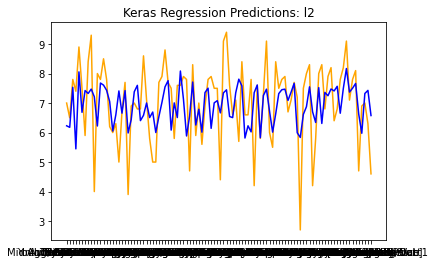

In [182]:
plt.plot(y_test[:100], color = 'orange')
plt.plot(preds_hist_3[:100], color = 'blue')
plt.title('Keras Regression Predictions: l2');